# tsam - 1. Example
Example usage of the time series aggregation module (tsam)
Date: 08.05.2017

Author: Leander Kotzur

Import pandas and the relevant time series aggregation class

In [1]:
%load_ext autoreload
%autoreload 2
import copy
import pandas as pd
import matplotlib.pyplot as plt
import tsam.timeseriesaggregation as tsam
%matplotlib inline

### Input data 

Read in time series from testdata.csv with pandas

In [2]:
raw = pd.read_csv('testdata.csv', index_col = 0)

Show a slice of the dataset

In [3]:
raw.head()

,GHI,T,Wind,Load
2009-12-31 23:30:00,0,-2.1,7.1,375.478394
2010-01-01 00:30:00,0,-2.8,8.6,364.541326
2010-01-01 01:30:00,0,-3.3,9.7,357.416844
2010-01-01 02:30:00,0,-3.2,9.8,350.191306
2010-01-01 03:30:00,0,-3.2,9.4,345.161449


Show the shape of the raw input data: 4 types of timeseries (GHI, Temperature, Wind and Load) for every hour in a year

In [4]:
raw.shape

(8760, 4)

Create a plot function for the temperature for a visual comparison of the time series

In [5]:
def plotTS(data, periodlength, vmin, vmax):
    fig, axes = plt.subplots(figsize = [6, 2], dpi = 100, nrows = 1, ncols = 1)
    stacked, timeindex = tsam.unstackToPeriods(copy.deepcopy(data), periodlength)
    cax = axes.imshow(stacked.values.T, interpolation = 'nearest', vmin = vmin, vmax = vmax)
    axes.set_aspect('auto')  
    axes.set_ylabel('Hour')
    plt.xlabel('Day')

    fig.subplots_adjust(right = 1.2)
    cbar=plt.colorbar(cax)    
    cbar.set_label('T [°C]')

Plot an example series - in this case the temperature

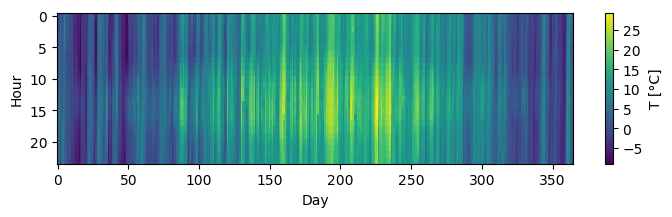

In [6]:
plotTS(raw['T'], 24, vmin = raw['T'].min(), vmax = raw['T'].max())

### Simple k-mean aggregation

Initialize an aggregation class object with k-mean as method for eight typical days, without any integration of extreme periods. Alternative clusterMethod's are 'averaging','hierarchical' and 'k_medoids'.

In [7]:
aggregation = tsam.TimeSeriesAggregation(raw, noTypicalPeriods = 8, hoursPerPeriod = 24, 
                                        clusterMethod = 'k_means')

Create the typical periods

In [8]:
typPeriods = aggregation.createTypicalPeriods()

Show shape of typical periods: 4 types of timeseries for 8*24 hours

In [9]:
typPeriods.shape

(192, 4)

Save typical periods to .csv file

In [10]:
typPeriods.to_csv('testperiods.csv')

Repredict the original time series based on the typical periods

In [11]:
predictedPeriods = aggregation.predictOriginalData()

Plot the repredicted data

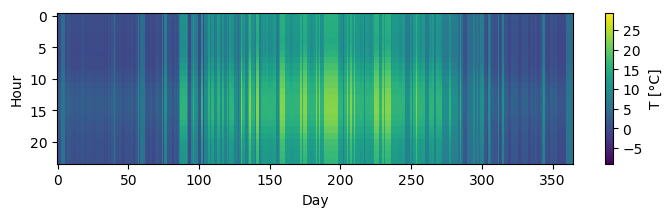

In [12]:
plotTS(predictedPeriods['T'], 24, vmin = raw['T'].min(), vmax = raw['T'].max())

As seen, they days with the minimal temperature are excluded. In case that they are required they can be added to the aggregation as follow.

### Hierarchical aggregation including extreme periods

Initialize a time series aggregation which integrates the day with the minimal temperature and the day with the maximal load as periods.

In [13]:
aggregation = tsam.TimeSeriesAggregation(raw, noTypicalPeriods = 8, hoursPerPeriod = 24, 
                                        clusterMethod = 'hierarchical', 
                                        extremePeriodMethod = 'new_cluster_center',
                                       addPeakMin = ['T'], addPeakMax = ['Load'] )

Create the typical periods

In [14]:
typPeriods = aggregation.createTypicalPeriods()

The aggregation can also be evaluated by indicators

In [15]:
aggregation.accuracyIndicators()

,MAE,RMSE,RMSE_duration
GHI,0.049942,0.093828,0.032105
Load,0.070473,0.099253,0.027539
T,0.067124,0.086290,0.031189
Wind,0.112975,0.144376,0.049884


Repredict the original time series based on the typical periods

In [16]:
predictedPeriodsWithEx = aggregation.predictOriginalData()

Plot repredicted data

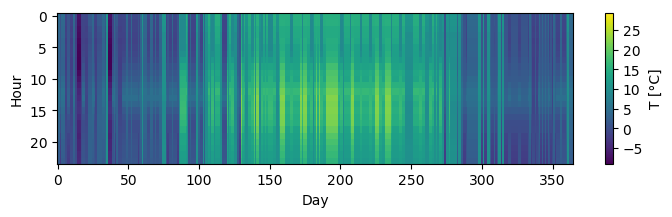

In [17]:
plotTS(predictedPeriodsWithEx['T'], 24, vmin = raw['T'].min(), vmax = raw['T'].max())

Now also the days with the minimal temperature are integrated into the typical periods.

### Comparison of the aggregations 
It was shown for the temperature, but both times all four time series have been aggregated. Therefore, we compare here also the duration curves  of the electrical load for the original time series, the aggregation with k-mean, and the hierarchical aggregation including peak periods.

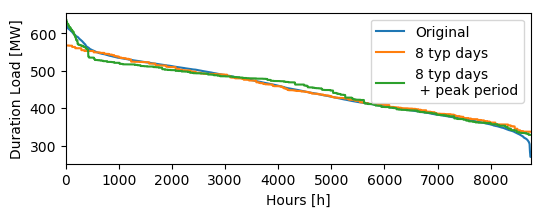

In [18]:
fig, axes = plt.subplots(figsize = [6, 2], dpi = 100, nrows = 1, ncols = 1)
raw['Load'].sort_values(ascending=False).reset_index(drop=True).plot(label = 'Original')
predictedPeriods['Load'].sort_values(ascending=False).reset_index(drop=True).plot(label = '8 typ days')
predictedPeriodsWithEx['Load'].sort_values(
    ascending=False).reset_index(drop=True).plot(label = '8 typ days \n + peak period')
plt.legend()
plt.xlabel('Hours [h]')
plt.ylabel('Duration Load [MW]')

Or as unsorted time series for an example week

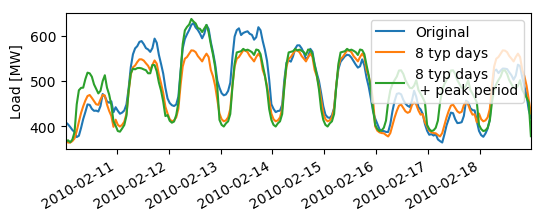

In [19]:
fig, axes = plt.subplots(figsize = [6, 2], dpi = 100, nrows = 1, ncols = 1)
raw['Load']['20100210':'20100218'].plot(label = 'Original')
predictedPeriods['Load']['20100210':'20100218'].plot(label = '8 typ days')
predictedPeriodsWithEx['Load']['20100210':'20100218'].plot(label = '8 typ days \n + peak period')
plt.legend()
plt.ylabel('Load [MW]')